In [365]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys

from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [2]:
# путь к данным
PATH_TO_FILE = r'C:\Users\Sergey\anaconda3\Scripts\ab_test_levels2.xlsx'

## Загрузка данных

In [3]:
# загружаем данные
df = pd.read_excel(PATH_TO_FILE)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\tFormula,\tUNIQUES(A);TOTALS(A);TOTALS(B);TOTALS(C);TOT...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\tA:,\tlevel_start,\tlevel_number,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка данных
* удалим nan
* соберем шапку таблицы
* заменим значения в колонке Formula
* заменим значения в колонке Segment
* переименуем колонки: [показатель].[характеристика показателя].[статистика]
* разделим на когорты A, B

In [5]:
# удаляем nan
df_notna = df.dropna().reset_index(drop = True)

# названия признаков
colnames = []
for val in df_notna.iloc[0].values:
    try:
        colnames.append(val.strip())
    except:
        colnames.append(val)

df_notna_c = df_notna.drop(0).rename(columns = dict(zip(df_notna.columns, colnames)))
df_notna_c = df_notna_c.astype(str).applymap(lambda val: val.strip()).replace('', np.nan)

# значения в Formula
Formula_unique_values = df_notna_c['Formula'].unique()
Formula_replacements = 'level.start.unique', 'level.start.total', 'level.won.total' ,'level.losed.total', 'level.quit.total'
Formula_d = dict(zip(Formula_unique_values, Formula_replacements))
df_notna_c['Formula'] = df_notna_c['Formula'].map(Formula_d)

# значения в Segment
Segment_unique_values = df_notna_c['Segment'].unique()
Segment_replacements = ['A', 'B']
Segment_d = dict(zip(Segment_unique_values, Segment_replacements))
df_notna_c['Segment'] = df_notna_c['Segment'].map(Segment_d)

# собираем level_number в один столбец
ser_level_number = df_notna_c.rename(columns = {'level_number' : 'level.number'})['level.number'].astype(np.float32).sum(1).astype(int)
df_notna_c = df_notna_c.drop('level_number', 1)
df_notna_c['level.number'] = ser_level_number

df_notna_c = df_notna_c.rename(columns = {df_notna_c.columns[2]:'event/player_total'})

# когорта A
df_A = df_notna_c[df_notna_c['Segment'] == 'A']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_A.columns.name = None

# когорта Б
df_B = df_notna_c[df_notna_c['Segment'] == 'B']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_B.columns.name = None

In [6]:
df_A.head()

,level.losed.total,level.quit.total,level.start.total,level.start.unique,level.won.total
level.number,,,,,
1,0,21,1756,1750,1716
2,0,18,1679,1672,1652
3,0,30,1621,1602,1587
4,7,42,1557,1525,1490
5,4,30,1429,1406,1383


## Игровой процесс

<img src="matryoshka_pipeline.png">

In [7]:
# кф корреляции
L_corr = []

# датасетов A, B
for flag, df in zip(('A', 'B'), (df_A, df_B)):
    # считаем попраные корреляции для всех признаков
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            col_A, col_B = df.columns[i], df.columns[j]
            ser1, ser2 = df[col_A], df[col_B]
            L_corr.append((flag, col_A, col_B, np.corrcoef(ser1, ser2).min()))  

# финальная таблица
df_corr_AB = pd.DataFrame(L_corr,\
                          columns = ['cohort', 'feature_1', 'feature_2', 'corr_coef'])

# собираем посчитанные корреляции в одну таблицу
L2_corr = []
for (f1, f2), _subdf in df_corr_AB.groupby(['feature_1', 'feature_2']):
    corr1, corr2 = _subdf['corr_coef'].round(4).values.tolist()
    L2_corr.append((f1, f2, corr1, corr2))  

# финальная таблица    
df2_corr_AB = pd.DataFrame(L2_corr,\
                           columns = ['feature_1', 'feature_2', 'corr.A', 'corr.B'])\
                .sort_values('corr.A')\
                .reset_index(drop = True)\
                .set_index(['feature_1', 'feature_2'])

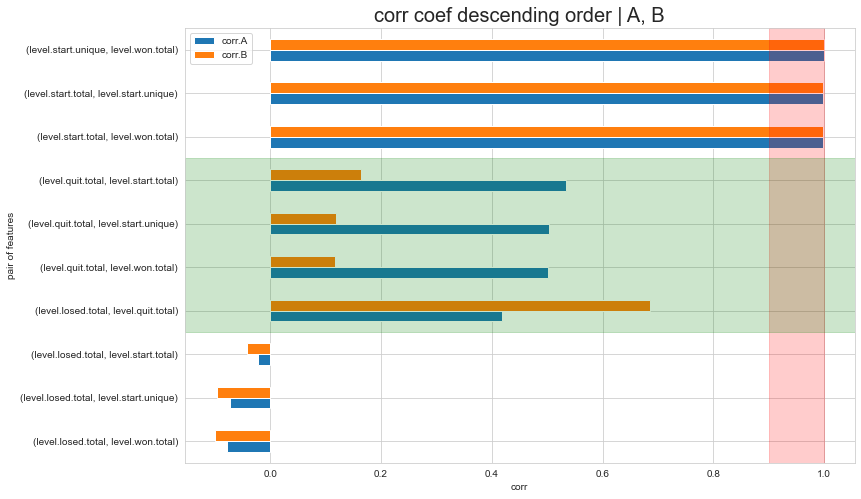

In [8]:
df2_corr_AB.plot(kind = 'barh', figsize = (12, 8))
plt.axvspan(.9, 1, color = 'red', alpha = .2)
plt.axhspan(2.5, 6.5, alpha = .2, color = 'green')
plt.title('corr coef descending order | A, B', fontsize =20)
plt.xlabel('corr')
plt.ylabel('pair of features')
plt.show()

#### Выводы:
* мультиколлинеарные признаки: ['level.start.total', 'level.won.total', 'level.start.unique'] (можно будет оставить один из них)
* пары признаков, корреляция между которыми сильно отличается в A, B
|признак1|признаки2|
|---|---|
|level.quit.total|level.won.total, level.start.unique, level.start.total|
|level.losed.total|level.quit.total, level.start.total|
* значение level.quit.total в когортах A, B различное


In [25]:
df_A['level.(quit.total/start.total)'] = df_A['level.quit.total'] / df_A['level.start.total']
df_B['level.(quit.total/start.total)'] = df_B['level.quit.total'] / df_B['level.start.total']

In [86]:
def _plot_line_AB(df_A, df_B, feature_name):
    '''Чертит признак (feature_name) от уровня (level.number) в когортах A, B (df_A, df_B)'''    
    
    # данные
    ser_A = df_A[feature_name]   
    top5_A = ser_A.sort_values(ascending = False).head()    
    ser_B = df_B[feature_name]
    top5_B = ser_B.sort_values(ascending = False).head()
    
    # фигура
    fig = plt.figure(figsize = (15, 5))
    
    # графики
    ser_A.plot(marker = '.')    
    plt.scatter(top5_A.index, top5_A.values, c = 'blue', s = 100, alpha = .5)
    ser_B.plot(marker = '.')
    plt.scatter(top5_B.index, top5_B.values, c = 'orange', s = 100, alpha = .5)    
    
    # легенда, подписи осей, название
    plt.legend(['A', 'B', 'top5.A', 'top5.B'])
    plt.ylabel(feature_name)
    plt.title('{} by levels | AB'.format(feature_name), fontsize = 20)    

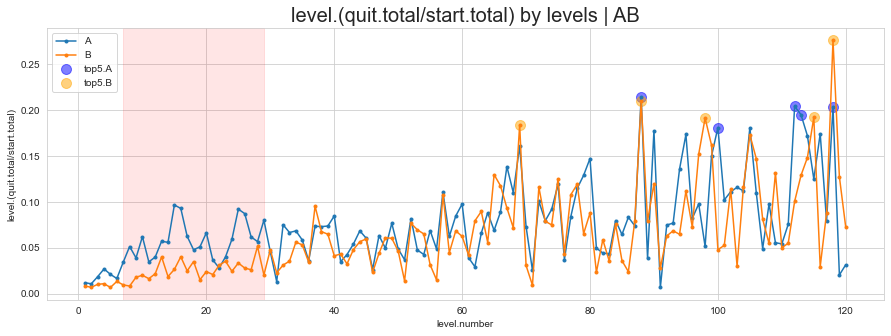

In [87]:
_plot_line_AB(df_A, df_B, feature_name='level.(quit.total/start.total)')
plt.axvspan(7, 29, alpha = .1, color ='red')
plt.show()

In [102]:
topN = 10
quit_start_top10_A = df_A['level.(quit.total/start.total)'].sort_values(ascending = False).head(topN).sort_index().index.tolist()
quit_start_top10_B = df_B['level.(quit.total/start.total)'].sort_values(ascending = False).head(topN).sort_index().index.tolist()

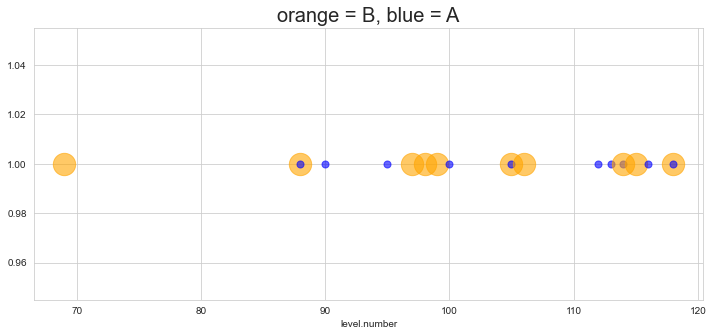

In [415]:
df_report_AB = pd.concat([pd.DataFrame(list(zip(['B'] * len(quit_start_top10_B), quit_start_top10_B)), columns = ['cohort', 'top10']),\
           pd.DataFrame(list(zip(['A'] * len(quit_start_top10_A), quit_start_top10_A)), columns = ['cohort', 'top10'])], 0)\
    .sort_values('top10')
df_report_AB.index = np.arange(df_report_AB.shape[0])
df_report_AB['val']= 1

fig = plt.figure(figsize=(12,5))
for _s, _ser in df_report_AB.groupby('top10'):
    xs = _ser['top10'].values.tolist()
    colors = _ser['cohort'].map({'A':'blue', 'B':'orange'}).values.tolist()
    for i in range(len(xs)):
        if colors[i] =='orange':
            plt.scatter(xs[i], 1, color = colors[i], s= 500, alpha = .6)
        else:
            plt.scatter(xs[i], 1, color = colors[i], s= 50, alpha = .6)
plt.xlabel('level.number')            
plt.title('orange = B, blue = A', fontsize = 20)
plt.show()

#### Выводы:
* когорта А имела бросала прохождение уровней (7- 29), в отличие от когорты Б. (уровни или скучные, или сложные)
* топ 10 бросаемых уровней когорты B сгруппированы в 2 группах (~90, ~115). это контрольные точки игры. Данные уровни бросались из-за усталости игроков(имели проблемы с прохождением). В когроте А конечный отрезок подобен конечному отрезку когорты B, а вот в середине явного пика сложности нет
* таким образом, на первый взгляд, уровни в когорте B сбалансированы лучше

In [306]:
tired_boring_A = df_A[(df_A['level.losed.total'] == 0) & (df_A['level.quit.total']!=0)]
print('dropping levels without lose | A')
print('{} | {}'.format('level.number', 'level.quit/start'))
print('----------------------------------')
for k, v in (tired_boring_A['level.quit.total'] / tired_boring_A['level.start.total']).items():
    print('{:^12} | {:^16.1%}'.format(k, v))

dropping levels without lose | A
level.number | level.quit/start
----------------------------------
     1       |       1.2%      
     2       |       1.1%      
     3       |       1.9%      
     6       |       1.7%      
     46      |       2.6%      
     50      |       4.9%      
     51      |       3.7%      
     82      |       4.4%      
     86      |       8.3%      
     91      |       0.7%      
     92      |       7.5%      
     94      |      13.6%      
     95      |      17.4%      
    116      |      17.4%      
    117      |       7.9%      
    119      |       2.0%      
    120      |       3.2%      


In [307]:
tired_boring_B = df_B[(df_B['level.losed.total'] == 0) & (df_B['level.quit.total']!=0)]
print('dropping levels without lose | B')
print('{} | {}'.format('level.number', 'level.quit/start'))
print('----------------------------------')
for k, v in (tired_boring_B['level.quit.total'] / tired_boring_B['level.start.total']).items():
    print('{:^12} | {:^16.1%}'.format(k, v))

dropping levels without lose | B
level.number | level.quit/start
----------------------------------
     1       |       0.8%      
     2       |       0.7%      
     4       |       1.1%      
     11      |       1.6%      
     50      |       4.6%      
     51      |       1.4%      
     56      |       1.5%      
     71      |       0.9%      
     81      |       2.3%      
     83      |       3.6%      
     85      |       3.6%      
     86      |       2.4%      
     89      |       7.9%      
     91      |       2.8%      
     92      |       6.3%      
     94      |       6.5%      
     95      |      11.2%      
     98      |      19.1%      
    100      |       4.8%      
    104      |      11.7%      
    109      |      13.2%      
    111      |       5.5%      
    116      |       2.9%      
    119      |      12.7%      
    120      |       7.2%      


#### Выводы:
* данные уровни были после череды сложных, люди бросали играть от усталости
* как видно, чем сложнее были уровни, тем больше людей уставало
* в когорте А первые 3 уровня были скучными (В Б такого нет)

In [308]:
df_A['level.churn'] = df_A['level.start.unique'].diff(-1) / df_A['level.start.unique']
df_B['level.churn'] = df_B['level.start.unique'].diff(-1) / df_B['level.start.unique']

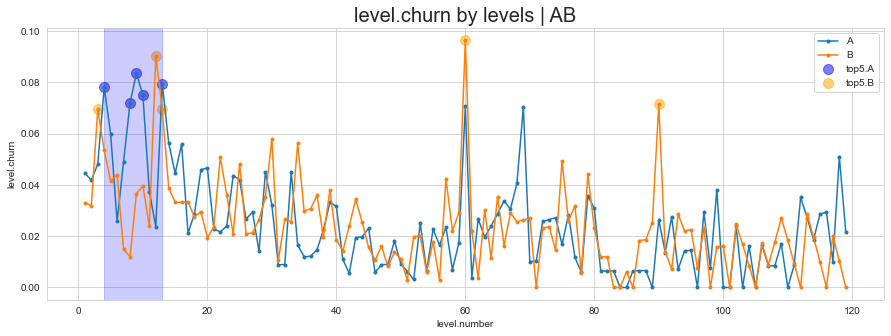

In [318]:
_plot_line_AB(df_A, df_B, feature_name='level.churn')
plt.axvspan(4, 13, alpha = .2, color = 'blue');

#### Выводы:
* В когорте A топ5 отточных уровней наблюдались  в начале игры (скучно)
* в когорте B ситуация немного исправилась, однако, люди прекращают играть из-за сложности уровней в середине/конце (данные уровни являются сложными и для когорты А, но все же менее сложными(особенно 59-60))
* учитывая, что это ровно середина игры, люди к этому готовы, и после 60 уходят не так активно, к тому же, после такого они готовы к финальным уровням


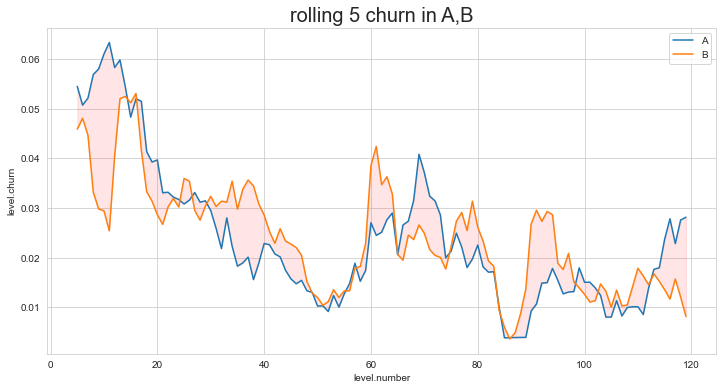

In [359]:
v_A= df_A['level.churn'].rolling(5).mean()
v_B=df_B['level.churn'].rolling(5).mean()

y1=v_A.values
y2 = v_B.values
x =v_A.index

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
v_A.plot(ax=ax)
v_B.plot(ax=ax)
ax.fill_between(x,y1,y2, alpha = .1,color ='red')
plt.legend(['A','B'])  
plt.ylabel('level.churn')
plt.title('rolling 5 churn in A,B', fontsize = 20)
plt.show()

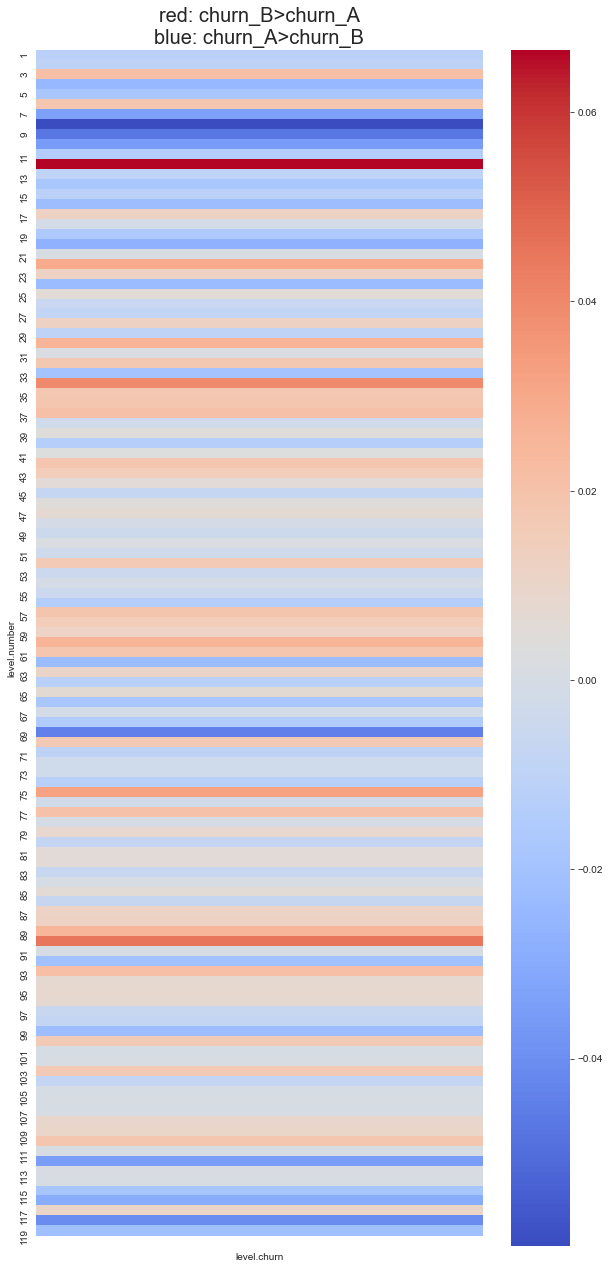

In [472]:
__ddf = (df_B['level.churn'] - df_A['level.churn']).to_frame()
plt.figure(figsize = (10, 22))
sns.heatmap(__ddf,\
            cmap= 'coolwarm')
plt.title('red: churn_B>churn_A\nblue: churn_A>churn_B', fontsize = 20)
plt.show()

In [479]:
scaler = MinMaxScaler()
serA = pd.Series(scaler.fit_transform(df_A[['level.start.unique']]).flatten(), index = df_A.index)
serB = pd.Series(scaler.fit_transform(df_B[['level.start.unique']]).flatten(), index = df_B.index)

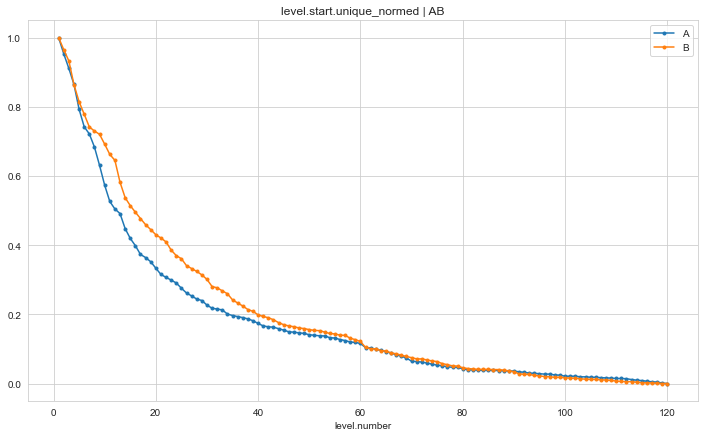

In [484]:

serA.plot(figsize = (12, 7), marker= '.')
serB.plot(marker= '.')
plt.title('level.start.unique_normed | AB')
plt.legend(['A','B'])
plt.show()

#### Выводы:
* как виодно, удержание B лучше удержания A до ~90 уровня